In [1]:
import pandas
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import sys
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read training and test files

In [2]:
data = pandas.read_csv('training.csv')
test = pandas.read_csv('test.csv')

Делаем кучу новых признаков. Больше не меньше! Если что-то будет лишнее, разберёмся с этим позже.

In [3]:
data['Rapidity'] = np.log( (np.sqrt(data['Mass']**2 + data['Pt']**2*np.cosh(data['Pseudorapidity'])**2) + 
                data['Pt']*np.sinh(data['Pseudorapidity']))/(np.sqrt(data['Mass']**2 + data['Pt']**2)) )
data['Rapidity_corrected'] = np.log( (np.sqrt(data['Corrected_mass']**2 + data['Pt']**2*np.cosh(data['Pseudorapidity'])**2) + 
                data['Pt']*np.sinh(data['Pseudorapidity']))/(np.sqrt(data['Corrected_mass']**2 + data['Pt']**2)) )
data['Pz'] = np.sinh(data['Pseudorapidity'])*data['Pt']
data['P'] = np.cosh(data['Pseudorapidity'])*data['Pt']
data['E'] = np.sqrt(data['P']**2 + data['Mass']**2)
data['E_corrected'] = np.sqrt(data['P']**2 + data['Corrected_mass']**2)
data['Pt_0'] = data['Pt'] - data['Pt_min']
data['gamma'] = data['E']/data['Mass']
data['gamma_corr'] = data['E_corrected']/data['Corrected_mass']
data['beta'] = np.sqrt(1 - 1/data['gamma']**2)
data['beta_corr'] = np.sqrt(1 - 1/data['gamma_corr']**2)
data['t'] = data['Flight_distance']/data['beta']
data['t_corr'] = data['Flight_distance']/data['beta_corr']
data['pt_coll'] = data['Pt_sum']/data['Pt']
data['E_div'] = data['E']/data['E_corrected']
data['M_div'] = data['Mass']/data['Corrected_mass']
data['gamma_div'] = data['gamma']/data['gamma_corr']
data['beta_div'] = data['beta']/data['beta_corr']

data['track_div'] = data['Tracks_number_passed']/data['Tracks_number']



test['Rapidity'] = np.log( (np.sqrt(test['Mass']**2 + test['Pt']**2*np.cosh(test['Pseudorapidity'])**2) + 
                test['Pt']*np.sinh(test['Pseudorapidity']))/(np.sqrt(test['Mass']**2 + test['Pt']**2)) )
test['Rapidity_corrected'] = np.log( (np.sqrt(test['Corrected_mass']**2 + test['Pt']**2*np.cosh(test['Pseudorapidity'])**2) + 
                test['Pt']*np.sinh(test['Pseudorapidity']))/(np.sqrt(test['Corrected_mass']**2 + test['Pt']**2)) )
test['Pz'] = np.sinh(test['Pseudorapidity'])*test['Pt']
test['P'] = np.cosh(test['Pseudorapidity'])*test['Pt']
test['E'] = np.sqrt(test['P']**2 + test['Mass']**2)
test['E_corrected'] = np.sqrt(test['P']**2 + test['Corrected_mass']**2)
test['Pt_0'] = test['Pt'] - test['Pt_min']
test['gamma'] = test['E']/test['Mass']
test['gamma_corr'] = test['E_corrected']/test['Corrected_mass']
test['beta'] = np.sqrt(1 - 1/test['gamma']**2)
test['beta_corr'] = np.sqrt(1 - 1/test['gamma_corr']**2)
test['t'] = test['Flight_distance']/test['beta']
test['t_corr'] = test['Flight_distance']/test['beta_corr']
test['pt_coll'] = test['Pt_sum']/test['Pt']
test['E_div'] = test['E']/test['E_corrected']
test['M_div'] = test['Mass']/test['Corrected_mass']
test['gamma_div'] = test['gamma']/test['gamma_corr']
test['beta_div'] = test['beta']/test['beta_corr']

test['track_div'] = test['Tracks_number_passed']/test['Tracks_number']


features = list(set(data.columns) - {'EventID', 'Label', 'Weight'})
print (features)
print (len(features))

['E_corrected', 'IP_chi2_sum', 'Pt_0', 'Vertex_chi2', 'IP_chi2', 'E', 'beta_div', 'gamma_corr', 'M_div', 't', 'Tracks_number', 'E_div', 'Mass', 'Tracks_number_passed', 'gamma', 'beta', 'Rapidity_corrected', 'Track_number_PV', 'gamma_div', 'Pt_sum', 't_corr', 'beta_corr', 'Pseudorapidity', 'Pt_min', 'Rapidity', 'pt_coll', 'track_div', 'Corrected_mass', 'Flight_distance', 'Pt', 'Pz', 'P']
32


In [4]:
import copy
from sklearn.model_selection import KFold, StratifiedKFold
class stacking:
    def __init__(self, clf, n):
        self.clf = list()
        for i in range(n):
             self.clf.append(copy.deepcopy(clf))
        self.n = n
    def fit_predict_proba(self, X, y, groups = None):
        kf = StratifiedKFold(n_splits=self.n)
        predictions = np.zeros((len(y),))
        i = 0
        for train_index, test_index in kf.split(X, y):
            self.clf[i].fit(X[train_index,:], y[train_index])
            predictions[test_index] = (self.clf[i].predict_proba(X[test_index,:]))[:, 1]
            i += 1
        return predictions
    def predict_proba(self, X):
        predictions = np.zeros((X.shape[0],))
        for i in range(self.n):
            predictions += self.clf[i].predict_proba(X)[:, 1]
        predictions = predictions/self.n
        return predictions
    
class stacking_regression:
    def __init__(self, clf, n):
        self.clf = list()
        for i in range(n):
             self.clf.append(copy.deepcopy(clf))
        self.n = n
    def fit_predict(self, X, y, groups = None):
        kf = KFold(n_splits=self.n)
        predictions = np.zeros((len(y),))
        i = 0
        for train_index, test_index in kf.split(X, y):
            self.clf[i].fit(X[train_index,:], y[train_index])
            predictions[test_index] = (self.clf[i].predict(X[test_index,:]))
            i += 1
        return predictions
    def predict(self, X):
        predictions = np.zeros((X.shape[0],))
        for i in range(self.n):
            predictions += self.clf[i].predict(X)
        predictions = predictions/self.n
        return predictions

# Удалённый пункт.

Я посмотрел в Flavours of physics, где предсказывали массы и использовали это в качестве фичи. Ну я решил это добвить потехи ради. Одно только понял, xgboost хорошо восстанавливает массу, раз. Во-вторых, Corrected_mass и Mass перепутаны местами(ну да и бог с ним). В оригинальной посылке эти фичи были, но не думаю, что они дают сильный прирост(просто было интересно попробовать), а потому чтобы у вас не считалось несколько лет всё это дело, я вырезал предсказание массы.

In [5]:
#features_m = list(set(data.columns) - {'EventID','Label', 'Weight', 'Mass', 'Corrected_mass'})
#print (features_m)
#print (len(features_m))
#
#mass_corr_pred = stacking_regression(clf=XGBRegressor(max_depth=4, n_estimators=10000, learning_rate=0.03, silent=False, min_child_weight=1, 
#             subsample=1, colsample_bytree=0.9, reg_alpha=0.01), n=10)
#train_corr_mass = mass_corr_pred.fit_predict(data[features_m].values, data.Corrected_mass.values)
#test_corr_mass = mass_corr_pred.predict(test[features_m].values)
#data['predicted_corr_mass'] = train_corr_mass
#test['predicted_corr_mass'] = test_corr_mass

#mass_pred = stacking_regression(clf=XGBRegressor(max_depth=5, n_estimators=10000, learning_rate=0.03, silent=False, min_child_weight=4, 
#             subsample=1, colsample_bytree=0.9, reg_alpha=0.01), n=10)

#train_mass = mass_pred.fit_predict(data[features_m].values, data.Mass.values)
#test_mass = mass_pred.predict(test[features_m].values)
#data['predicted_mass'] = train_mass
#test['predicted_mass'] = test_mass

# Стекинг!

А давайте затренируем 3 xgboost с абсолютно разными параметрами и посмотрим, что получится.

In [6]:
pred_stack_1 = stacking(clf=XGBClassifier(max_depth=100, n_estimators=6, learning_rate=0.3, 
                                        silent=False, min_child_weight=1, 
             subsample=0.9, colsample_bytree=0.7, reg_alpha=1), n=10)
pred_train_1 = pred_stack_1.fit_predict_proba(data[features].values, data.Label.values)
pred_test_1 = pred_stack_1.predict_proba(test[features].values)

data['predictions_1'] = pred_train_1
test['predictions_1'] = pred_test_1

In [7]:
pred_stack_2 = stacking(clf=XGBClassifier(max_depth=20, n_estimators=25, learning_rate=0.1, 
                                        silent=False, min_child_weight=1, 
             subsample=0.9, colsample_bytree=0.7, reg_alpha=1), n=10)
pred_train_2 = pred_stack_2.fit_predict_proba(data[features].values, data.Label.values)
pred_test_2 = pred_stack_2.predict_proba(test[features].values)

data['predictions_2'] = pred_train_2
test['predictions_2'] = pred_test_2

In [8]:
pred_stack = stacking(clf=XGBClassifier(max_depth=6, n_estimators=250, learning_rate=0.03, 
                                        silent=False, min_child_weight=1, 
             subsample=0.9, colsample_bytree=0.9, reg_alpha=1), n=10)
pred_train_3 = pred_stack.fit_predict_proba(data[features].values, data.Label.values)
pred_test_3 = pred_stack.predict_proba(test[features].values)

data['predictions_3'] = pred_train_3
test['predictions_3'] = pred_test_3

Самая бесполезная фича импульс, Track_number_PV и Track_number. Первое удивительно, вторые две, в принципе, ожидаемо.

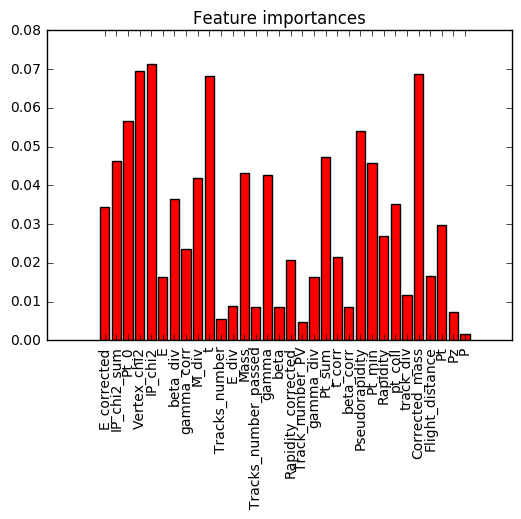

In [9]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(pred_stack_2.clf[0].feature_importances_)), pred_stack_2.clf[0].feature_importances_,
       color="r", align="center")
plt.xticks(range(len(features)), features, rotation=90)
plt.xlim()
plt.show()

# Магическое усреднение
Некая магическая формула, которая работает. Смысл можно понять так: это нечто вроде геометрического среднего, но не совсем.
Все классификаторы очень уверенные, а потому просто складывать и усреднять эти предсказания хорошо, но ещё лучше перемножать.

Под сильным классификатором я подразумеваю такой, который даёт очень смещённые к 1 предсказания. Для них хорошо перемножать вероятности.

(0, 1)

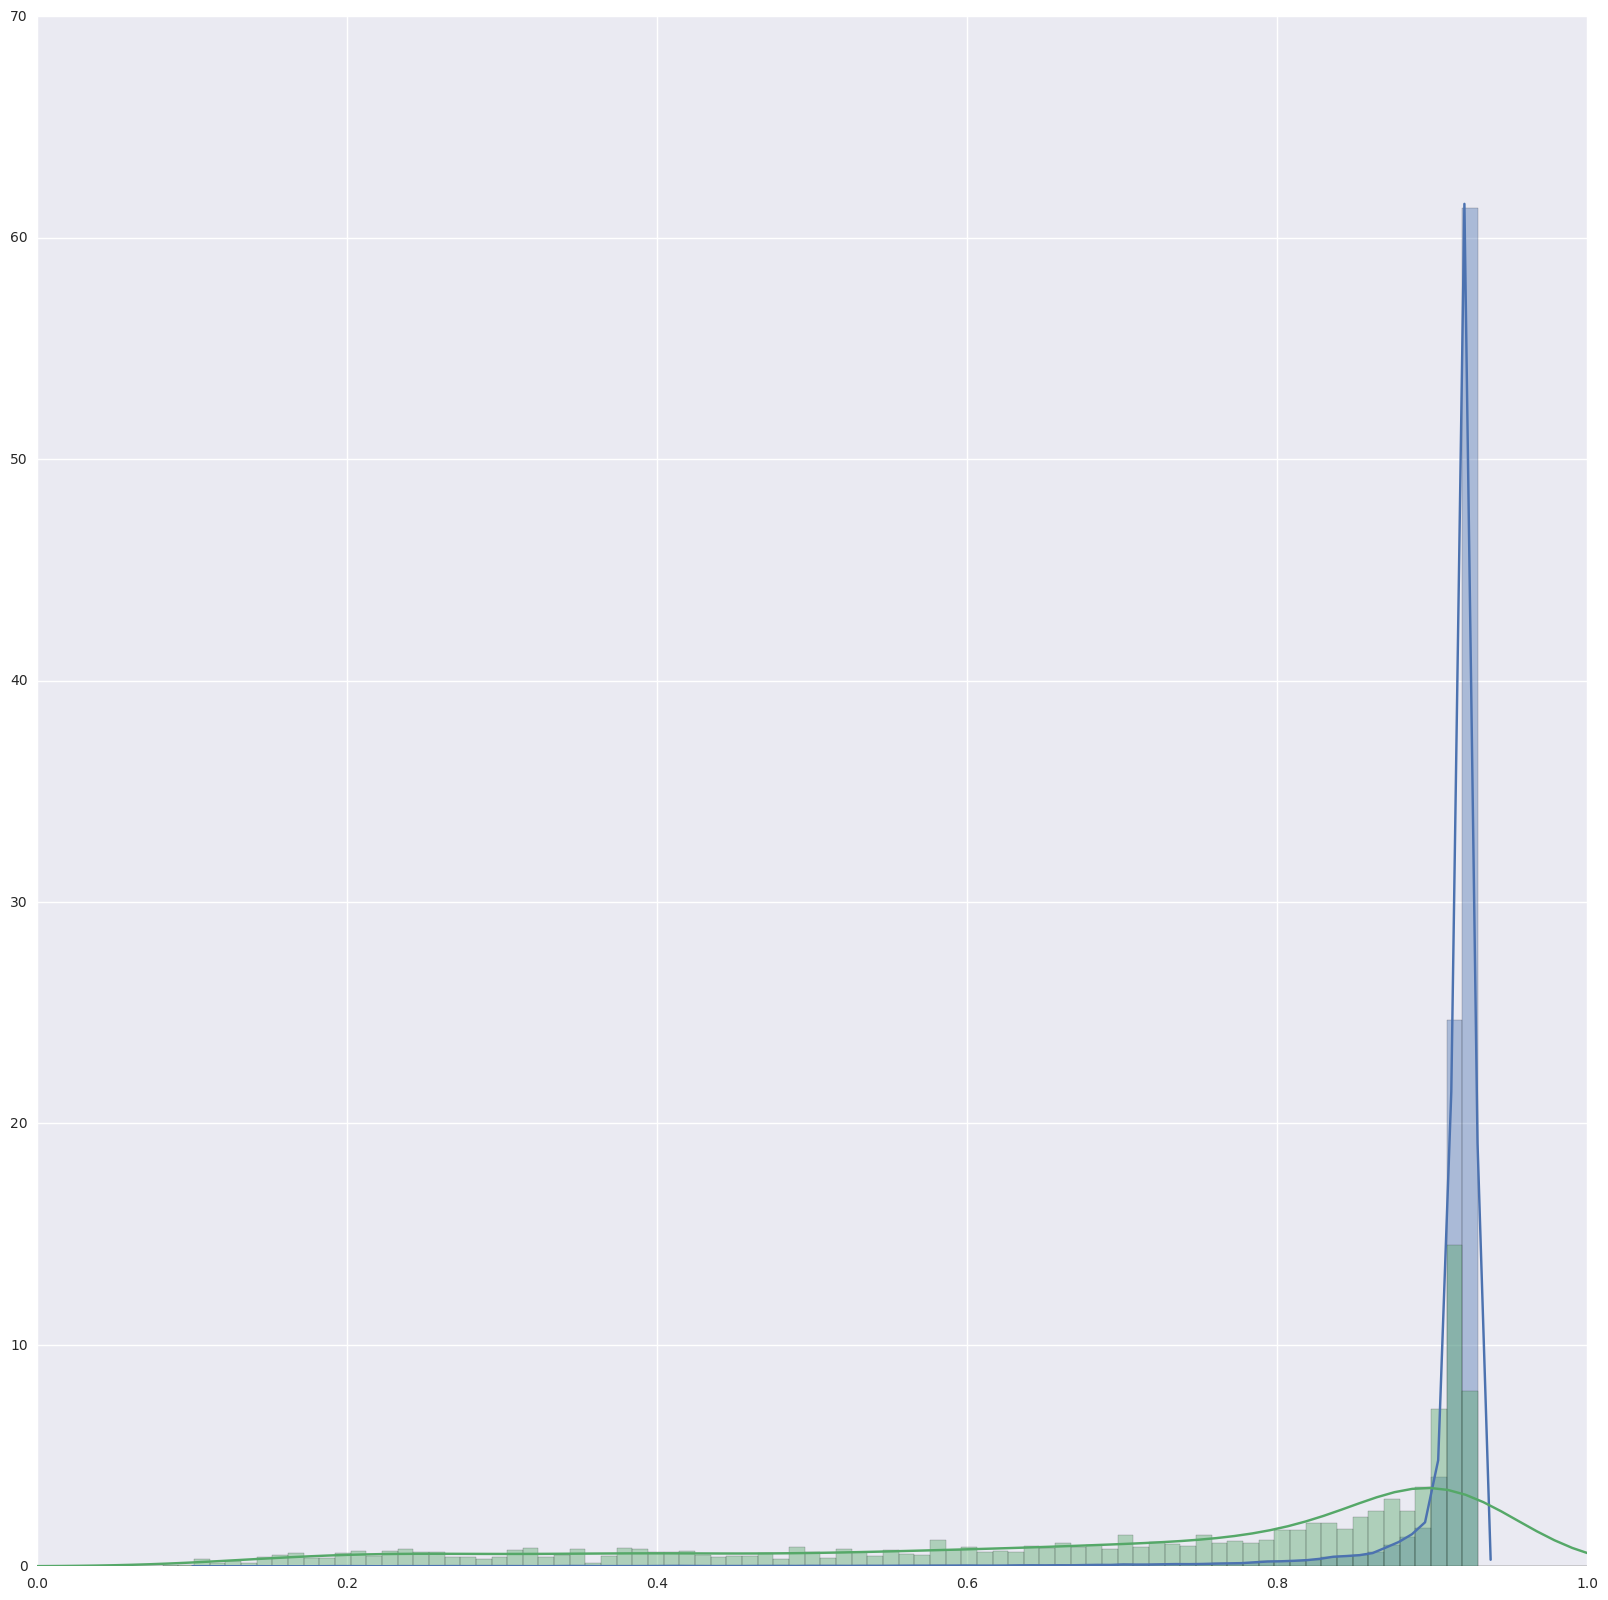

In [10]:
import seaborn as sns
signal_hits = data.loc[(data.Label == 1)]
noise_hits = data.loc[(data.Label == 0)]
points1 = signal_hits['predictions_1'].values
points2 = noise_hits['predictions_1'].values

fig, ax = plt.subplots(figsize=(20,20))

sns.distplot(points1, bins=np.linspace(0,1,100));
sns.distplot(points2, bins=np.linspace(0,1,100));
plt.xlim((0,1))

In [11]:
data['stacking'] = data['predictions_1']**0.1*data['predictions_2']**1.9*data['predictions_3']
test['stacking'] = test['predictions_1']**0.1*test['predictions_2']**1.9*test['predictions_3']

Посмотрим на график стэкинга. Вот, другое дело:)

(0, 1)

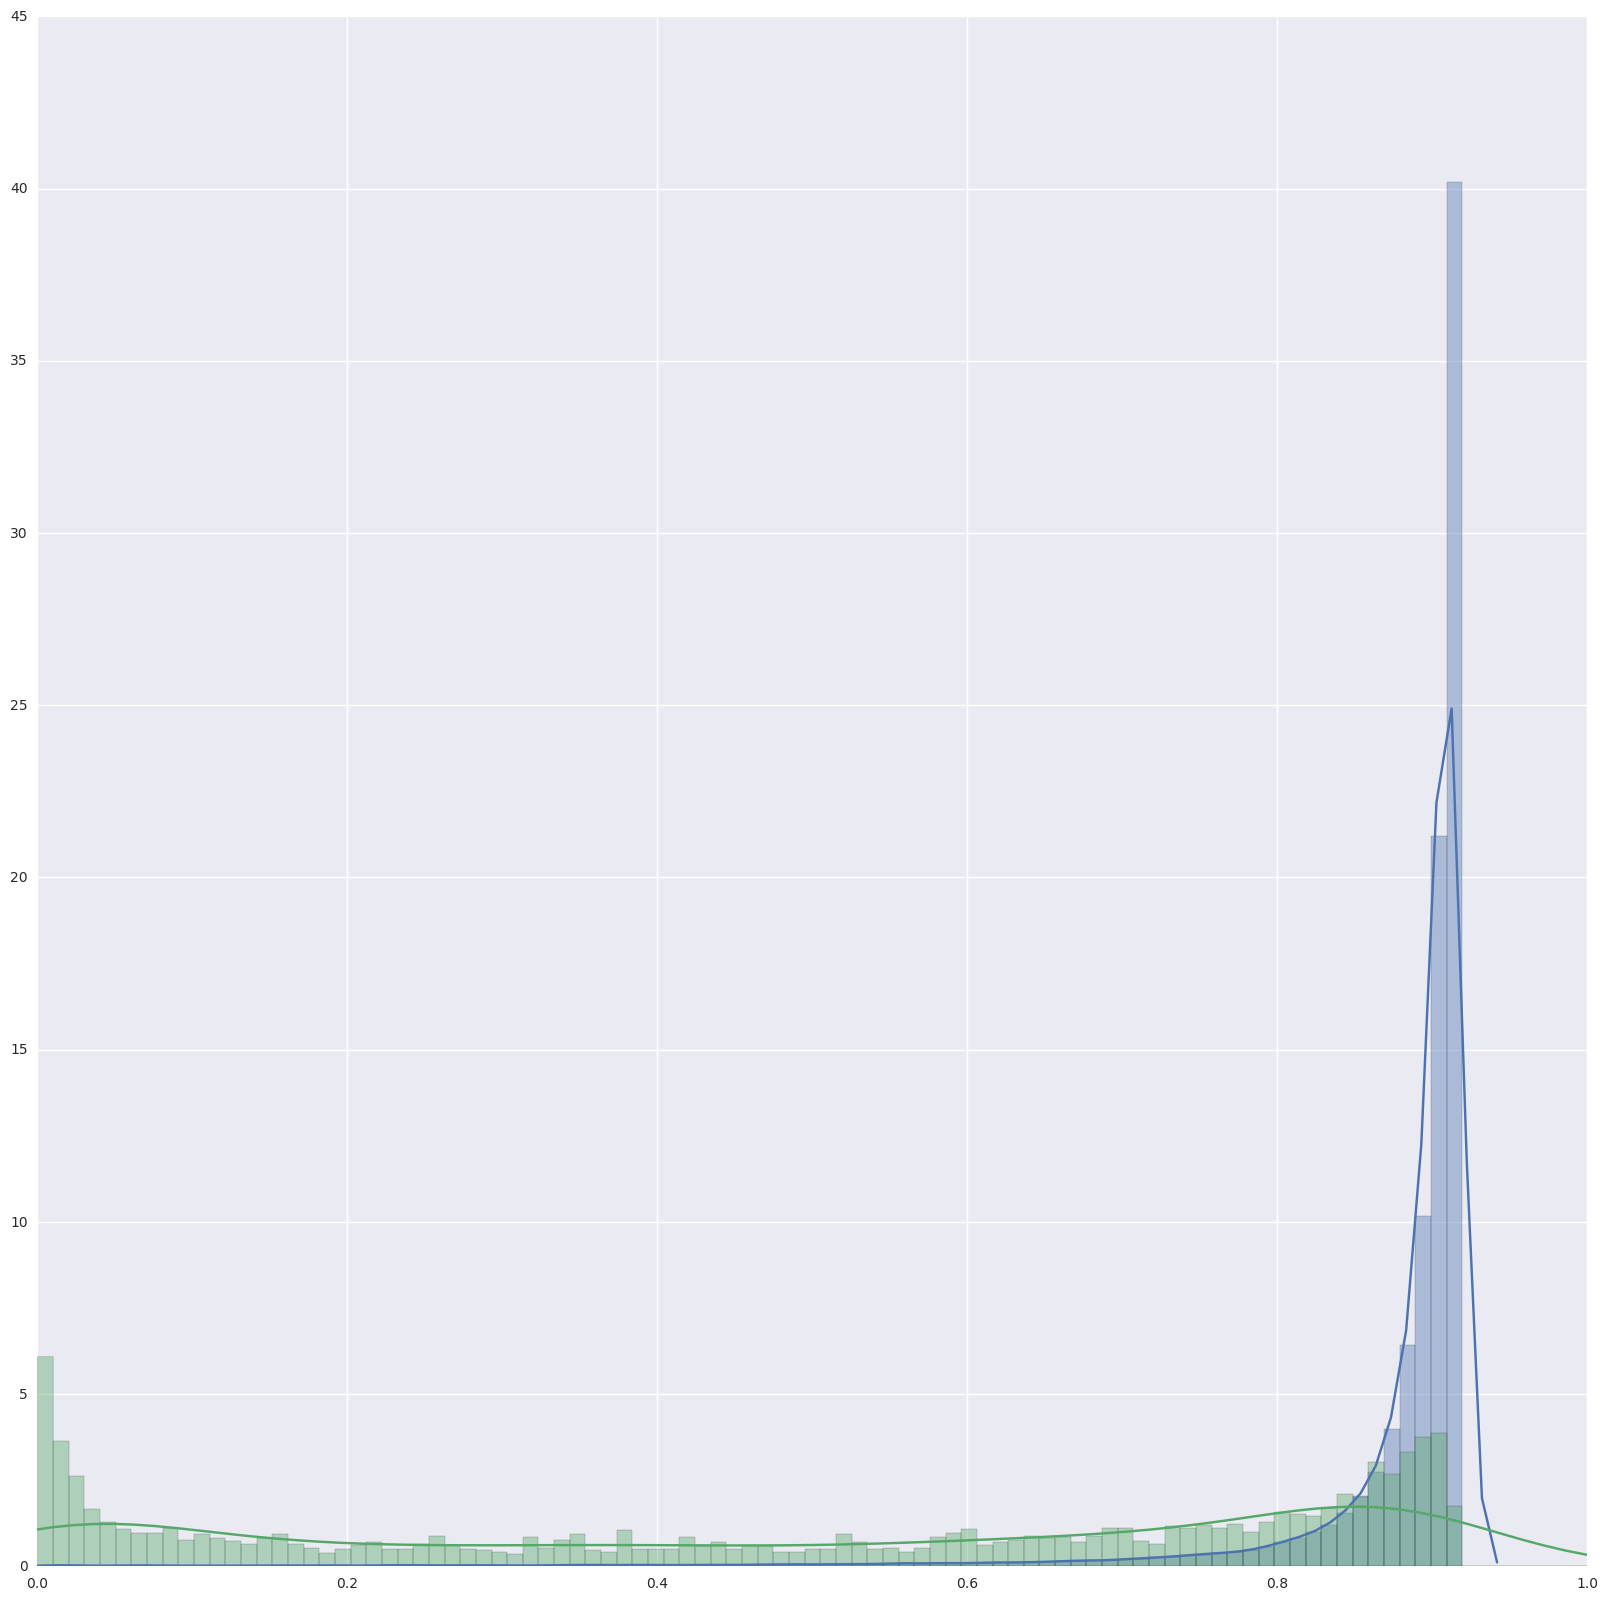

In [12]:
signal_hits = data.loc[(data.Label == 1)]
noise_hits = data.loc[(data.Label == 0)]
points1 = signal_hits['stacking'].values
points2 = noise_hits['stacking'].values

fig, ax = plt.subplots(figsize=(20,20))

sns.distplot(points1, bins=np.linspace(0,1,100));
sns.distplot(points2, bins=np.linspace(0,1,100));
plt.xlim((0,1))

In [13]:
features = list(set(data.columns) - {'EventID', 'Label', 'Weight'})

print (features)
print (len(features))

['E_corrected', 'IP_chi2_sum', 'Pt_0', 'Vertex_chi2', 'IP_chi2', 'E', 'beta_div', 'gamma_corr', 'M_div', 't', 'Tracks_number', 'E_div', 'predictions_1', 'Mass', 'Tracks_number_passed', 'gamma', 'predictions_2', 'stacking', 'beta', 'Rapidity_corrected', 'Track_number_PV', 'gamma_div', 'Pt_sum', 't_corr', 'beta_corr', 'Pseudorapidity', 'Pt_min', 'Rapidity', 'pt_coll', 'track_div', 'predictions_3', 'Corrected_mass', 'Flight_distance', 'Pt', 'Pz', 'P']
36


# Постановка новой задачи

Классифицировать эвенты по отдельным реакциям очень странно. Хорошо было бы как-то сделать признаки для события как единого целого. Начнём со всяких квантилей.

In [14]:
data_grouped = data.groupby('EventID')

X_data_min = data_grouped[features].min().values
data_grouped_max = data_grouped[features].max()
X_data_max = data_grouped_max.values
data_grouped_25 = data_grouped[features].quantile(q=0.25)
X_data_q25 = data_grouped_25.values
data_grouped_median = data_grouped[features].median()
X_data_q50 = data_grouped_median.values
data_grouped_75 = data_grouped[features].quantile(q=0.75)
X_data_q75 = data_grouped_75.values
data_grouped_85 = data_grouped[features].quantile(q=0.85)



test_grouped_test = test.groupby('EventID')

X_test_min = test_grouped_test[features].min().values
test_grouped_max = test_grouped_test[features].max()
X_test_max = test_grouped_max.values
test_grouped_25 = test_grouped_test[features].quantile(q=0.25)
X_test_q25 = test_grouped_25.values
test_grouped_median = test_grouped_test[features].median()
X_test_q50 = test_grouped_median.values
test_grouped_75 = test_grouped_test[features].quantile(q=0.75)
X_test_q75 = test_grouped_75.values

In [15]:
X_data = np.concatenate((X_data_max, X_data_min, X_data_q25, X_data_q50, X_data_q75),
                       axis=1)
X_test = np.concatenate((X_test_max, X_test_min, X_test_q25, X_test_q50, X_test_q75),
                       axis=1)

def compute_mean(event_ids, values):
    number_of_sv_in_event = np.bincount(event_ids)
    return np.bincount(event_ids, weights=values) / number_of_sv_in_event

events_ids = np.unique(data.EventID)

events_labels = compute_mean(data.EventID, data.Label)[events_ids]

Кроме этого добавим отдельно реакции, которые будут представителями события.

In [16]:
idx = data.groupby(['EventID'])['stacking'].transform(max) == data['stacking']
idx_test = test.groupby(['EventID'])['stacking'].transform(max) == test['stacking']

In [17]:
X_rep_train = data.sort('stacking', ascending=False).groupby('EventID').first()[features].values
X_rep_test = test.sort('stacking', ascending=False).groupby('EventID').first()[features].values

/home/acapello/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/home/acapello/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [18]:
X_data = np.concatenate((X_data, X_rep_train),
                       axis=1)
X_test = np.concatenate((X_test, X_rep_test),
                       axis=1)

In [19]:
print (X_data.shape)
print (X_test.shape)
print (events_labels.shape)

(16235, 216)
(84000, 216)
(16235,)


# Финальный ансамбль

In [20]:
fin_stack_1 = stacking(clf=XGBClassifier(max_depth=100, n_estimators=50, learning_rate=0.3, 
                                        silent=False, min_child_weight=1, 
             subsample=0.9, colsample_bytree=0.7, reg_alpha=1), n=10)
fin_train_1 = fin_stack_1.fit_predict_proba(X_data, events_labels)
fin_test_1 = fin_stack_1.predict_proba(X_test)

In [21]:
fin_stack_2 = stacking(clf=XGBClassifier(max_depth=5, n_estimators=1000, learning_rate=0.02, 
                                        silent=False, min_child_weight=1, 
             subsample=0.9, colsample_bytree=0.7, reg_alpha=1), n=10)
fin_train_2 = fin_stack_2.fit_predict_proba(X_data, events_labels)
fin_test_2 = fin_stack_2.predict_proba(X_test)

In [22]:
fin_stack_3 = stacking(clf=XGBClassifier(max_depth=20, n_estimators=200, learning_rate=0.1, 
                                        silent=False, min_child_weight=1, 
             subsample=0.9, colsample_bytree=0.7, reg_alpha=1), n=10)
fin_train_3 = fin_stack_3.fit_predict_proba(X_data, events_labels)
fin_test_3 = fin_stack_3.predict_proba(X_test)

Здесь мы опять делаем тот же трюк, геометрическое усреднение.

In [23]:
train_stack_fin = fin_train_1**0.15*fin_train_2**3*fin_train_3**0.7
test_stack_fin = fin_test_1**0.15*fin_test_2**3*fin_test_3**0.7

## Prepare submission to kaggle

In [24]:
ids = np.arange(0, 84000,1)

ml_prediction = pd.DataFrame({
        "Label": test_stack_fin}, 
        index=ids)
ml_prediction.to_csv("ml.csv", index_label='EventID', float_format='%.16f')

In [25]:
from IPython.display import FileLink
FileLink("ml.csv")

/home/acapello/Desktop/HighEnergyML2/ml.csv

(0, 1)

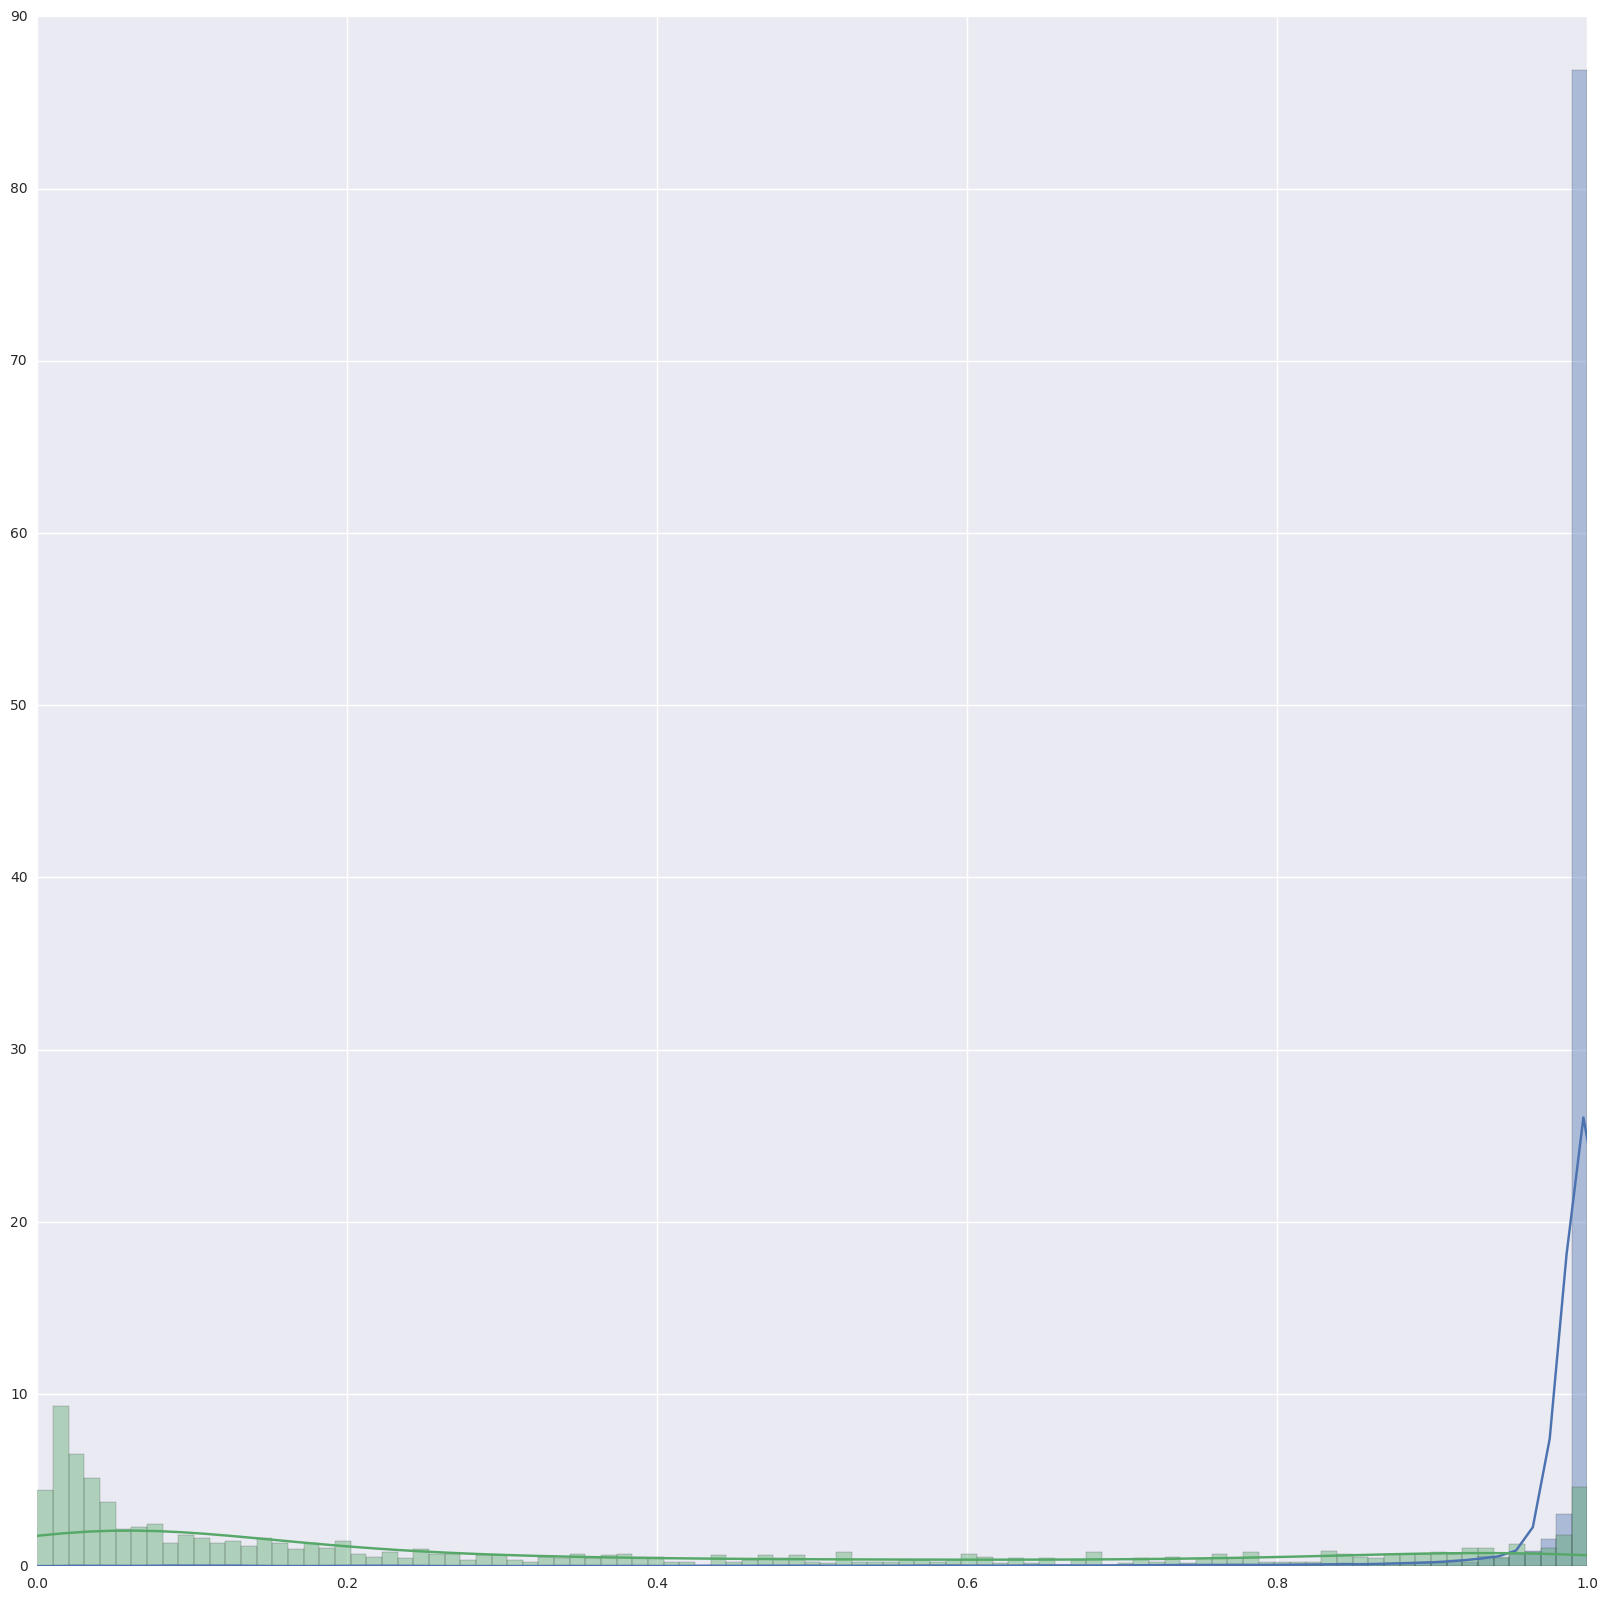

In [26]:
signal_hits = data.loc[(data.Label == 1)]
noise_hits = data.loc[(data.Label == 0)]
points1 = fin_train_2[events_labels == 1]
points2 = fin_train_2[events_labels == 0]

fig, ax = plt.subplots(figsize=(20,20))

sns.distplot(points1, bins=np.linspace(0,1,100));
sns.distplot(points2, bins=np.linspace(0,1,100));
plt.xlim((0,1))

(0, 1)

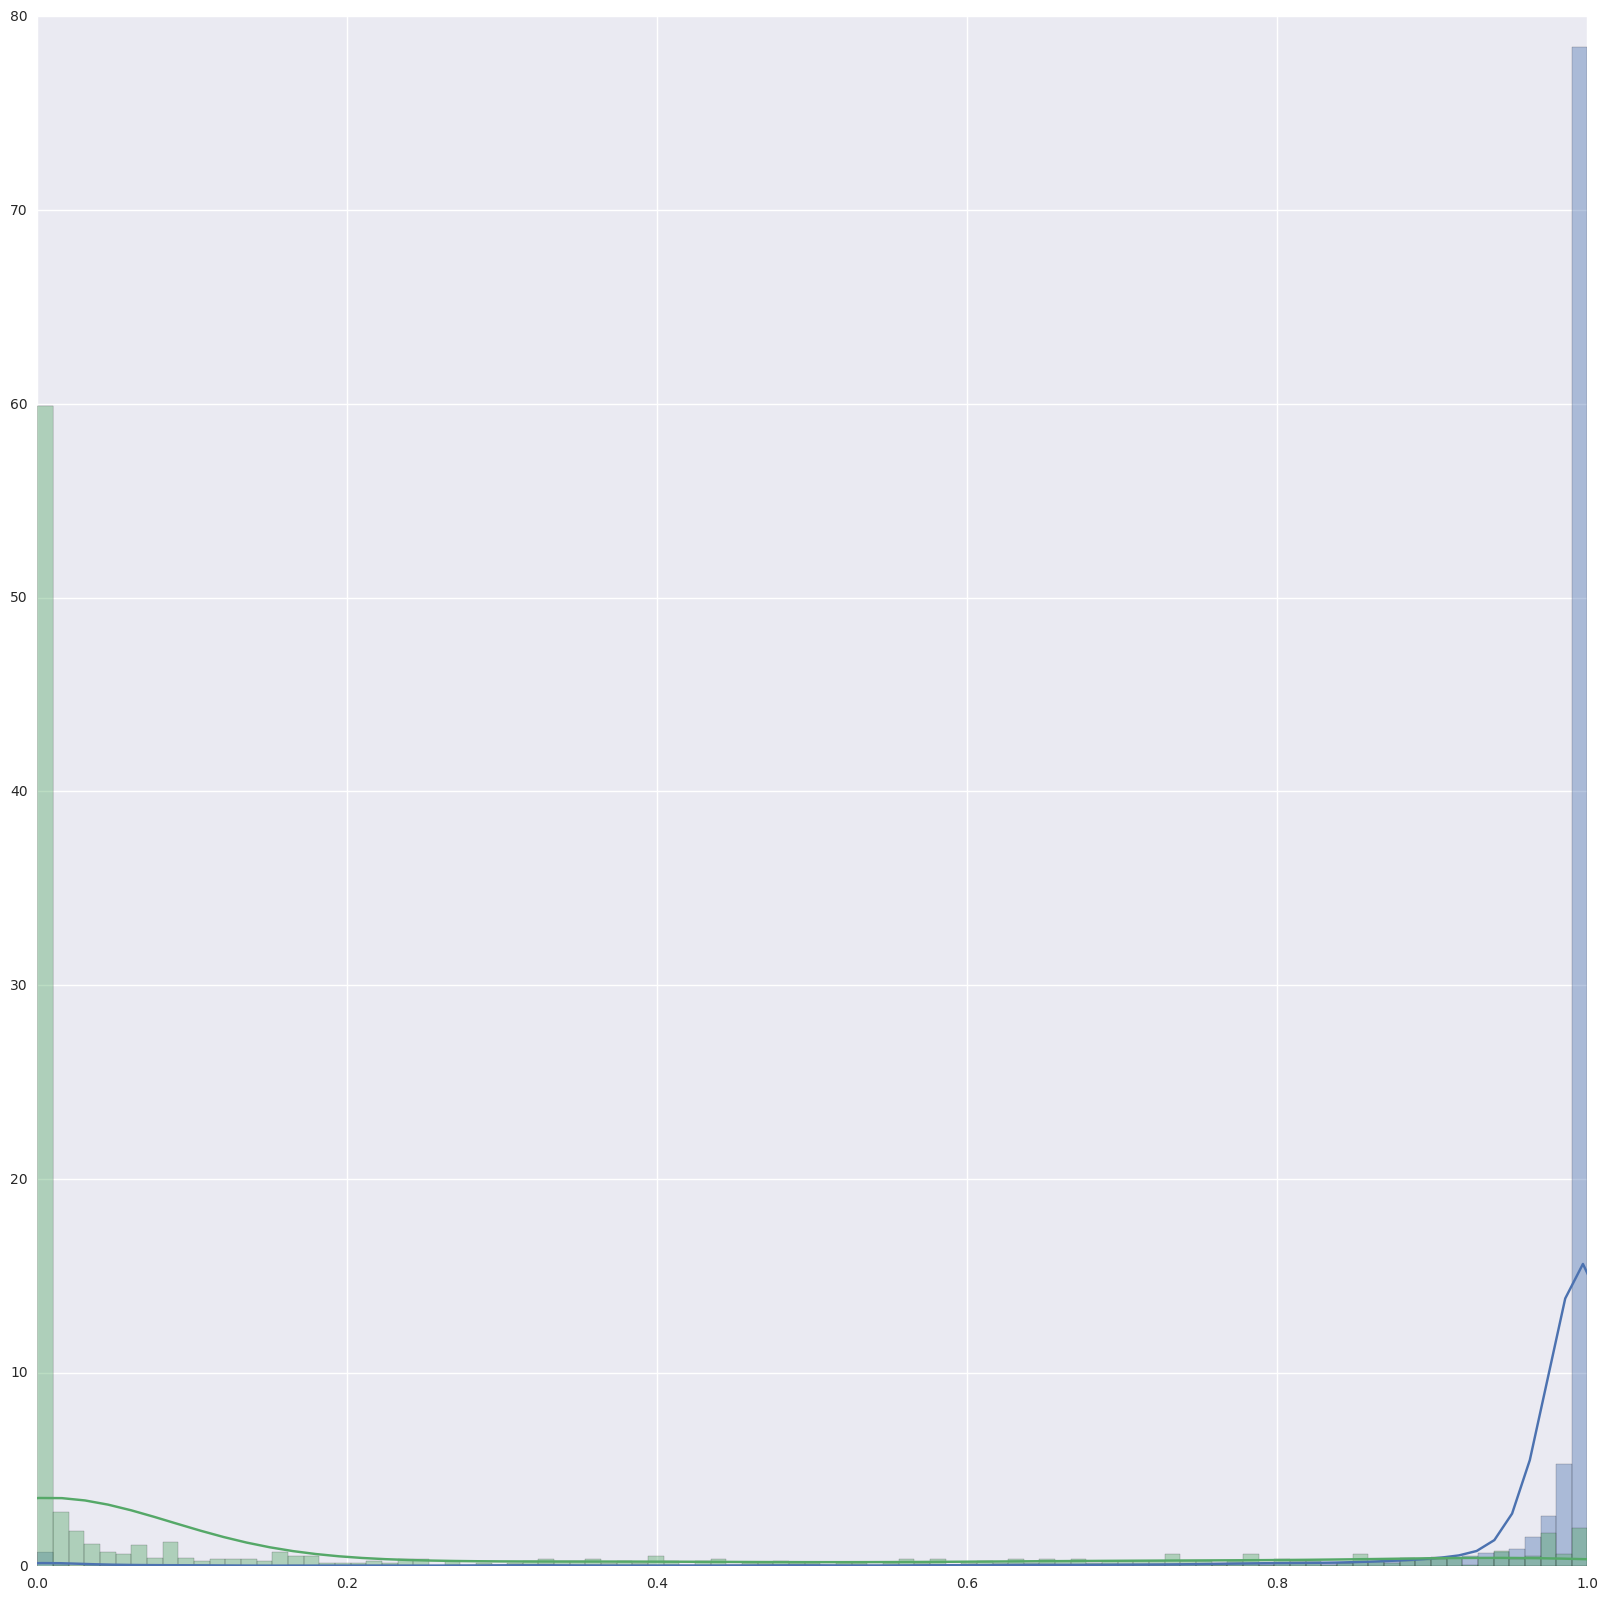

In [27]:
signal_hits = data.loc[(data.Label == 1)]
noise_hits = data.loc[(data.Label == 0)]
points1 = train_stack_fin[events_labels == 1]
points2 = train_stack_fin[events_labels == 0]

fig, ax = plt.subplots(figsize=(20,20))

sns.distplot(points1, bins=np.linspace(0,1,100));
sns.distplot(points2, bins=np.linspace(0,1,100));
plt.xlim((0,1))

# Дополнительно

1) Ещё была попытка релизовать Keras сеть с реккурентной сетью(LSTM), что могло бы позволить обрабатывать события как единое целое. Но нейронка просто ставила всем событиям 1, независимо от передаваемых параметров весов классов, функций потерь, регуляризаций, дропаутов... Не то что бы это была проблема нейронной цепи, скорее я не умею ещё правильно с ними работать:) Но мне кажется, это потенциально интересный путь.

2) Является ли это решение физическим: оно не использует какие-то данные, которые зависили бы от реализации детектора, только вполне стандартные параметры, как масса, энергия и т.д. Поэтому, думаю, да, подобные деревья можно использовать в эксперименте. Хотя я всё же плохо понимаю, что значит физическое решение.

Отдельно, конечно, стоит сказать, что всё это считается долго, а вычислительные ресурсы на LHC это дефицитный ресурс, а потому подобное решение, скорее всего, будет не особо востребовано.